In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

# import shutup
# shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIS
import matplotlib
import matplotlib.pyplot as plt
import mediapy
from rich.pretty import pprint
from tqdm.auto import tqdm

from agents.dynamics_aware_iql import GCIQLAgent
from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

GLOBAL_KEY = jax.random.key(42)

,,

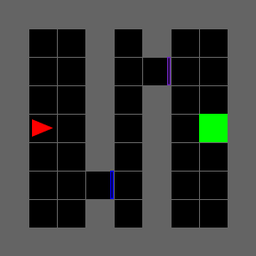
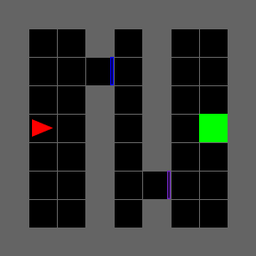
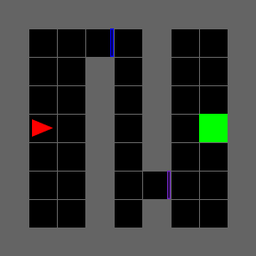

In [2]:
from envs.minigrid.doors_grid import DynamicsGeneralization_Doors, MinigridWrapper

# Train dynamics
layouts = []
for i in [0, 1, 2]:
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=200)
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    env.reset()
    
    layouts.append(env.render())
    
mediapy.show_images(layouts, width=256, height=256)

In [3]:
from envs.minigrid.env_utils import random_exploration, q_learning

train_layout_data = []
NUM_TRAIN_LAYOUTS = 5
NUM_TRAIN_STEPS = 100
NUM_TRAIN_EPISODES = 2000

for i in tqdm(range(NUM_TRAIN_LAYOUTS)):
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=NUM_TRAIN_STEPS, agent_start_pos=None)
    env._gen_grid = partial(env._gen_grid, layout_type=i)
    env = MinigridWrapper(env)
    dataset, env = random_exploration(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, num_mdp=NUM_TRAIN_LAYOUTS)
    #dataset, env = q_learning(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, epsilon=0.75, num_mdp=NUM_TRAIN_LAYOUTS)
    train_layout_data.append(dataset)
    
# ds, env = random_exploration(env)
# env.visualize_coverage()
pprint(jax.tree.map(lambda x: x.shape, train_layout_data[0]))

  0%|          | 0/5 [00:00<?, ?it/s]

{
│   'actions': (198000,),
│   'layout_type': (198000, 5),
│   'next_observations': (198000, 2),
│   'observations': (198000, 2),
│   'terminals': (198000,)
}

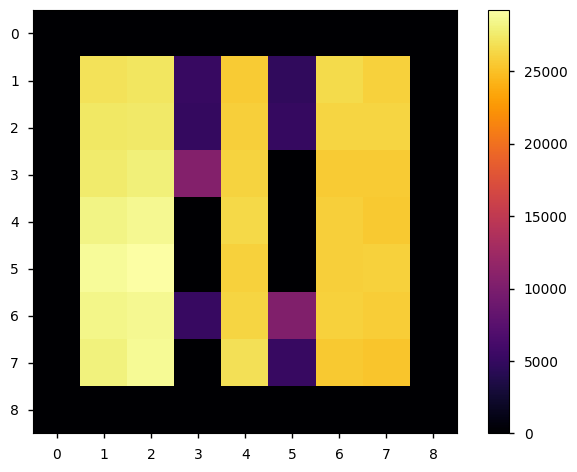

In [4]:
coverage_map = np.zeros(shape=(env.env.unwrapped.width, env.env.unwrapped.height))
for layout in train_layout_data:
    for obs in layout['observations']:
        obs = obs.astype(np.int16)
        coverage_map[obs[1], obs[0]] += 1
        
plt.imshow(coverage_map, cmap='inferno', vmin=0)
plt.colorbar()
plt.show()

In [5]:
import functools
from utils.datasets import Dataset, GCDataset

with initialize(version_base=None, config_path="../configs/"):
    iql_config = compose(config_name='entry.yaml', overrides=['experiment=gciql_dynamics.yaml', f'agent.number_of_meta_envs={NUM_TRAIN_LAYOUTS}']) #gciql
    iql_config = OmegaConf.to_container(iql_config, resolve=True)
    pprint(iql_config)

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)
np.save(f"../aux_data/gciql_dyn_doors", arr=jax.device_get(whole_data))
# whole_data = np.load("/home/m_bobrin/ZeroShotRL/aux_data/iql_door_data_meta.npy", allow_pickle=True).item()
print(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=iql_config['agent'])

{
│   'seed': 42,
│   'run_group': 'gciql',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 1000000,
│   'log_interval': 5000,
│   'eval_interval': 5000,
│   'eval_tasks': None,
│   'eval_episodes': 1,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'gciql',
│   │   'discrete': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.2,
│   │   'value_p_trajgoal': 0.8,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 1.0,
│   │   'actor_p_randomgoal': 0.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'lr': 0.0003,
│   │   'batch_size': 256,
│   │   'const_std': True,
│   │   'actor_hidden_dims': [512, 512, 512],
│   │   'value_hidden_dims': [512, 512, 512],
│   │   'layer_norm': True,
│   │   'actor_loss': 'awr',
│   │   'alpha': 0.003,
│   │   'use_film': False,
│   │   'use_context': True,
│   │   'dyn_encoder_warmup_steps': 50000,
│   │   'n_blocks': 4,
│   │   'n_heads': 4,
│   │   'emb_dim': 72,
│   │   'mlp_dim': 256,
│   │   'output_dim': 4,
│   │   'context_len': 100,
│   │   'number_of_meta_envs': 5,
│   │   'use_masked_attention': False,
│   │   'use_mean_embedding': True,
│   │   'cosine_schedule': False,
│   │   'world_pred_hidden': [128, 128, 128],
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'expectile': 0.9
│   },
│   'env': {'env_name': 'doors_context', 'discrete': True},
│   'tags': ['dynamics_gciql', 'discrete']
}

{'actions': (990000,), 'layout_type': (990000, 5), 'next_observations': (990000, 2), 'observations': (990000, 2), 'terminals': (990000,)}


In [ ]:
from agents.dynamics_aware_iql import GCIQLAgent

example_batch = gc_whole_dataset.sample(1)
iql_agent = GCIQLAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], env.env.action_space.n - 1),
    config=iql_config['agent']
)
if iql_config['agent']['use_context']:
    batch = gc_whole_dataset.sample(1, layout_type=0, context_length=NUM_TRAIN_STEPS)[1]
    dynamics_emb = iql_agent.network.select('dynamic_transformer')(batch['traj_states'],
                                                                batch['traj_actions'],
                                                                batch['traj_next_states'],
                                                                train=False)
    pprint(jax.tree.map(lambda x: x.shape, batch))
    iql_agent.update(batch, batch, train_context_embedding=True)
else:
    batch = gc_whole_dataset.sample(1)
    pprint(jax.tree.map(lambda x: x.shape, batch))
    iql_agent.update(batch, train_context_embedding=False)

{'actions': (99,), 'layout_type': (99, 5), 'next_observations': (99, 2), 'observations': (99, 2), 'terminals': (99,)}


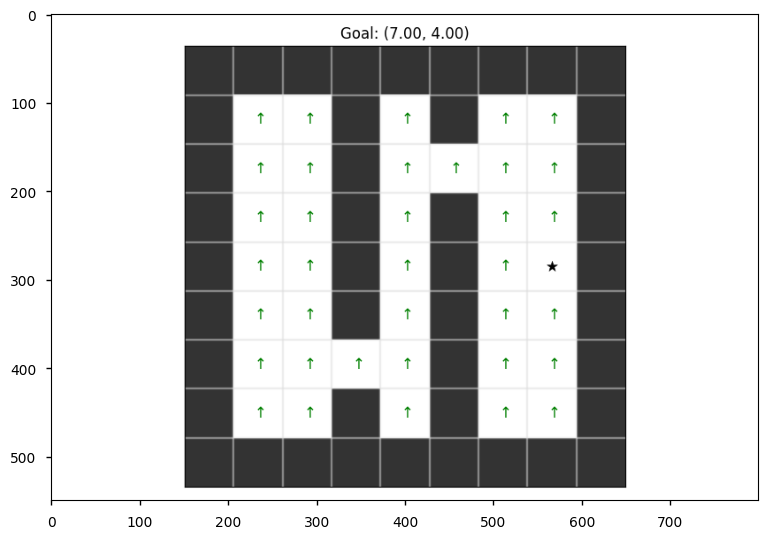

In [ ]:
from functools import partial
from utils.evaluation import supply_rng
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def get_canvas_image(canvas):
    canvas.draw() 
    out_image = np.asarray(canvas.buffer_rgba())
    return out_image

def policy_image_grid(env, dataset, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_policy(env, dataset, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def plot_policy(env, dataset, fig=None, ax=None, title=None, action_fn=None, **kwargs):
    action_names = [
            r'$\leftarrow$', r'$\rightarrow$', r'$\uparrow$', r'$\downarrow$' #'↑', '↓', '←', '→'#
        ]
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)
    
    goal = kwargs.get('goal', None)
    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            action = action_fn(np.concatenate([[x], [y]], -1)).squeeze()
            action_name = action_names[action]
            ax.text(x, y, action_name, ha='center', va='center', fontsize='large', color='green')
            
    ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
    ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
        
    if title:
        ax.set_title(title)
        
    return fig, ax

def visualize_policy_image(layout_type):
    mdp_type = np.zeros((iql_config['agent']['number_of_meta_envs'], )) if iql_config['agent']['number_of_meta_envs'] > 1 else None
    if mdp_type is not None:
        if layout_type == 0:
            mdp_type[0] = 1
        elif layout_type == 1:
            mdp_type[1] = 1
        else:
            mdp_type[2] = 1
            
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False,
                                    max_steps=NUM_TRAIN_STEPS)#iql_config['agent']['context_len'] if iql_config['agent']['use_context'] else None)
    env._gen_grid = partial(env._gen_grid, layout_type=layout_type)
    env = MinigridWrapper(env)
    dynamics_embedding=None
    obs, info = env.reset()
    goal = info.get("goal_pos", None)
    
    if iql_config['agent']['use_context']:
        dataset_inference, env = random_exploration(env, num_episodes=1, layout_type=layout_type, num_mdp=NUM_TRAIN_LAYOUTS)
        print(jax.tree.map(lambda x: x.shape, dataset_inference))
        dynamics_embedding_mean, dynamics_mean_std = iql_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None,:,None],
                                                                                    dataset_inference['next_observations'][None], train=False, return_embedding=True)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_mean_std)
        dynamics_embedding=dynamics_embedding.squeeze()
        mdp_type=None
        
    example_batch = gc_whole_dataset.sample(1)
    pred_policy_img = policy_image_grid(env, example_batch,
                                                    action_fn=partial(supply_rng(iql_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))),
                                                                    goals=goal, mdp_type=mdp_type, dynamics_embedding=dynamics_embedding, temperature=0.0),
                                                    goal=goal)
    return pred_policy_img

pred_policy_img = visualize_policy_image(layout_type=0)
plt.imshow(pred_policy_img)
plt.tight_layout()

{'actions': (99,), 'layout_type': (99, 5), 'next_observations': (99, 2), 'observations': (99, 2), 'terminals': (99,)}


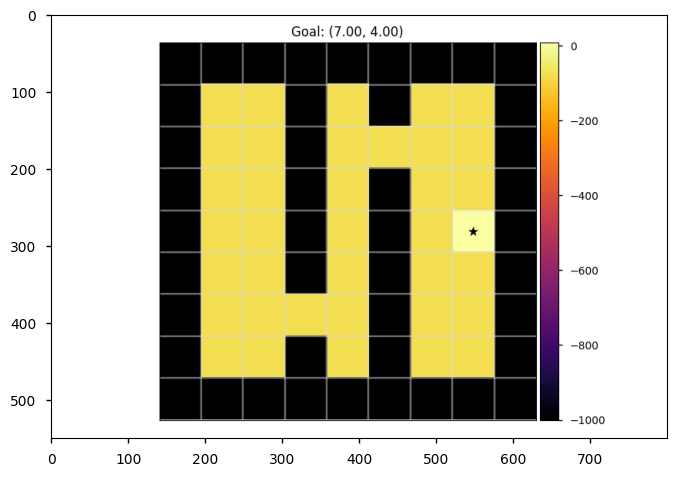

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def value_image_fourrooms(env, dataset, value_fn, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_value_image_grid(env, dataset, value_fn, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

def value_fn(agent, obs, goal, action, mdp_type=None, dynamics_embedding=None):
    q1, q2 = agent.network.select('critic')(obs, goal, action, mdp_num=mdp_type, dynamics_embedding=dynamics_embedding)
    q = jnp.minimum(q1, q2)
    return q / 0.02

def plot_value_image_grid(env, dataset, value_fn, action_fn, fig=None, ax=None, title=None, **kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    goal = kwargs.get('goal', None)
    grid = env.get_grid_array()
    ax = env.plot_grid(ax=ax, grid=grid)

    for (y, x), value in np.ndenumerate(grid):
        if value == 1 or value == 4:
            action = action_fn(np.concatenate([[x], [y]], -1)).squeeze()
            grid[y, x] = jax.device_get(value_fn(np.concatenate([[x], [y]], -1), goal, action))
            
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(grid, cmap='inferno', vmin=-1000)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if goal is not None:
        ax.set_title('Goal: ({:.2f}, {:.2f})'.format(goal[0], goal[1])) 
        ax.scatter(goal[0], goal[1], s=80, c='black', marker='*')
    return fig, ax
#jnp.all(self.dataset['layout_type'] == jax.nn.one_hot(jnp.array([layout_label]), self.config['number_of_meta_envs']), axis=-1)
def visualize_value_image(layout_type):
    mdp_type = np.zeros((iql_config['agent']['number_of_meta_envs'], ))
    if mdp_type is not None:
        if layout_type == 0:
            mdp_type[0] = 1
        elif layout_type == 1:
            mdp_type[1] = 1
        else:
            mdp_type[2] = 1
            
    env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False,
                                    max_steps=NUM_TRAIN_STEPS)#iql_config['agent']['context_len'] if iql_config['agent']['use_context'] else None)
    env._gen_grid = partial(env._gen_grid, layout_type=layout_type)
    env = MinigridWrapper(env)
    dynamics_embedding=None
    obs, info = env.reset()
    goal = info.get("goal_pos", None)
    if iql_config['agent']['use_context']:
        dataset_inference, env = random_exploration(env, num_episodes=1, layout_type=layout_type, num_mdp=NUM_TRAIN_LAYOUTS)
        print(jax.tree.map(lambda x: x.shape, dataset_inference))
        dynamics_embedding_mean, dynamics_mean_std = iql_agent.network.select('dynamic_transformer')(dataset_inference['observations'][None], dataset_inference['actions'][None, :, None],
                                                                                    dataset_inference['next_observations'][None], train=False, return_embedding=True)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_mean_std)
        dynamics_embedding = dynamics_embedding.squeeze()
        mdp_type=None
        
    pred_value_img = value_image_fourrooms(env, example_batch,
                                value_fn=partial(value_fn, iql_agent, mdp_type=mdp_type, dynamics_embedding=dynamics_embedding), action_fn=partial(supply_rng(iql_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))),
                                                                    goals=goal, mdp_type=mdp_type, temperature=0.0, dynamics_embedding=dynamics_embedding), goal=goal)
    return pred_value_img

pred_value_img = visualize_value_image(0)
plt.imshow(pred_value_img)


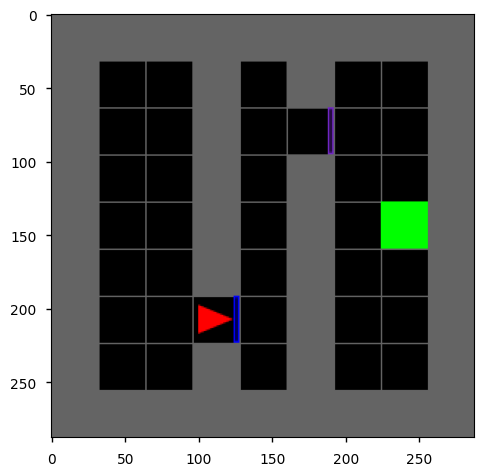

In [ ]:
env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=200, agent_start_pos=(3, 6))
env._gen_grid = partial(env._gen_grid, layout_type=0)
env = MinigridWrapper(env)
env.reset()
plt.imshow(env.render())

{'actions': (99,), 'layout_type': (99, 5), 'next_observations': (99, 2), 'observations': (99, 2), 'terminals': (99,)}
{'actions': (99,), 'layout_type': (99, 5), 'next_observations': (99, 2), 'observations': (99, 2), 'terminals': (99,)}
{'actions': (99,), 'layout_type': (99, 5), 'next_observations': (99, 2), 'observations': (99, 2), 'terminals': (99,)}
{'actions': (99,), 'layout_type': (99, 5), 'next_observations': (99, 2), 'observations': (99, 2), 'terminals': (99,)}
{'actions': (99,), 'layout_type': (99, 5), 'next_observations': (99, 2), 'observations': (99, 2), 'terminals': (99,)}
{'actions': (99,), 'layout_type': (99, 5), 'next_observations': (99, 2), 'observations': (99, 2), 'terminals': (99,)}


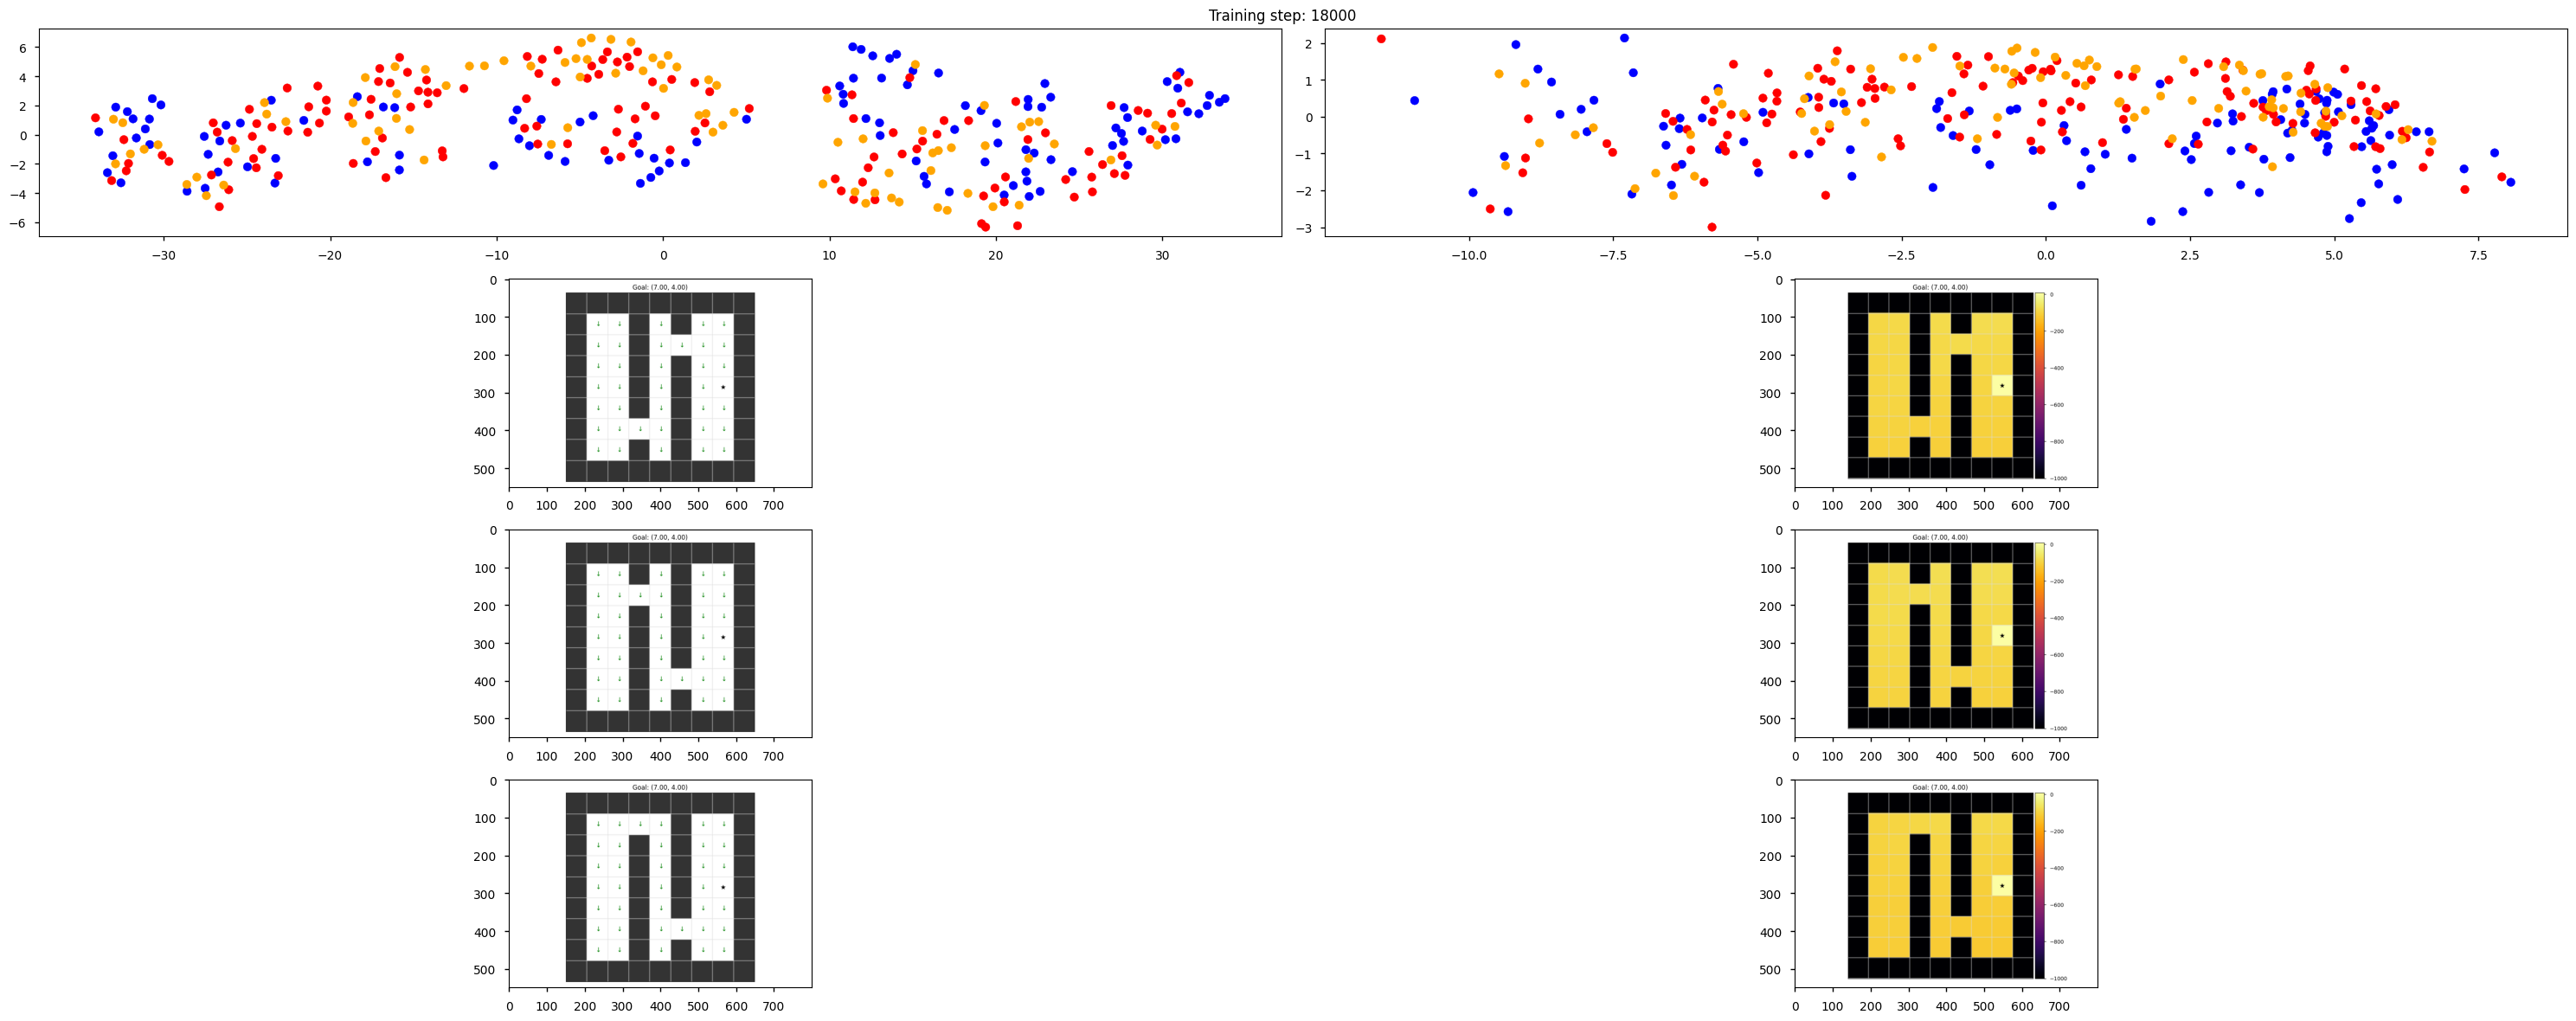

KeyboardInterrupt: 

In [ ]:
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap

pbar = tqdm(range(40_000))
obs, info = env.reset()
goal = info.get("goal_pos")

# with jax.disable_jit():
if iql_config['agent']['use_context']:
    plot_layouts = []
    for i in range(NUM_TRAIN_LAYOUTS):
        cur_layout = gc_whole_dataset.sample(256, layout_type=i, context_length=NUM_TRAIN_STEPS)[1]
        plot_layouts.append(cur_layout)
    plot_layouts = functools.reduce(concatenate_dicts, plot_layouts)

    first_layout_indxs = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == 6.0), 1))[0]
    first_layout_trajs = jax.tree_util.tree_map(lambda arr: arr[first_layout_indxs], plot_layouts)

    sec_layout_indxs = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == 2.0), 1))[0]
    sec_layout_trajs = jax.tree_util.tree_map(lambda arr: arr[sec_layout_indxs], plot_layouts)

    third_layout_indxs = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == 1.0), 1))[0]
    third_layout_trajs = jax.tree_util.tree_map(lambda arr: arr[third_layout_indxs], plot_layouts)

    plot_layouts = jax.tree.map(lambda x, y, z: jnp.concatenate([x, y, z]), first_layout_trajs, sec_layout_trajs, third_layout_trajs)
    colors = ['blue'] * first_layout_trajs['traj_actions'].shape[0] + ['red'] * sec_layout_trajs['traj_actions'].shape[0] +\
        ['orange'] * third_layout_trajs['traj_actions'].shape[0]

for update_steps in pbar:
    key = jax.random.fold_in(GLOBAL_KEY, update_steps)
    if not iql_config['agent']['use_context']:
        batch = gc_whole_dataset.sample(iql_config['agent']['batch_size'])
        iql_agent, update_info = iql_agent.update(batch, train_context_embedding=False)
    else:
        # batch, batch_context, _ = gc_whole_dataset.sample(iql_config['agent']['batch_size'], layout_type=update_steps % NUM_TRAIN_LAYOUTS,
        #                                                     context_length=iql_config['agent']['context_len'])
        # _, negative_context, _ = gc_whole_dataset.sample(iql_config['agent']['batch_size'], layout_type=(update_steps + 1) % NUM_TRAIN_LAYOUTS,
        #                                                     context_length=iql_config['agent']['context_len'])
        _, batch, _ = gc_whole_dataset.sample(iql_config['agent']['batch_size'], layout_type=update_steps % NUM_TRAIN_LAYOUTS,
                                                            context_length=NUM_TRAIN_STEPS)
        iql_agent, update_info = iql_agent.update(batch, batch, train_context_embedding=True if update_steps < 30_000 else False)
        
    if update_steps % 1_000 == 0:
        clear_output()
        if iql_config['agent']['use_context']:
            fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(30, 12))
            dynamics_embedding_mean, std = iql_agent.network.select('dynamic_transformer')(plot_layouts['traj_states'], plot_layouts['traj_actions'],
                                                                            plot_layouts['traj_next_states'], train=False)
            dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=key, shape=dynamics_embedding_mean.shape) * jnp.exp(std)
            tsne = TSNE(random_state=42, perplexity=30).fit_transform(dynamics_embedding)
            x, y = tsne[:, 0], tsne[:, 1]
            axs[0, 0].scatter(x, y, color=colors)
            
            pca = PCA().fit_transform(dynamics_embedding)
            x, y = pca[:, 0], pca[:, 1]
            axs[0, 1].scatter(x, y, color=colors)

            pred_policy_img = visualize_policy_image(layout_type=0)
            axs[1,0].imshow(pred_policy_img)
            pred_value_img = visualize_value_image(layout_type=0)
            axs[1, 1].imshow(pred_value_img)
            
            pred_policy_img = visualize_policy_image(layout_type=1)
            axs[2,0].imshow(pred_policy_img)
            pred_value_img = visualize_value_image(layout_type=1)
            axs[2, 1].imshow(pred_value_img)
            
            pred_policy_img = visualize_policy_image(layout_type=2)
            axs[3,0].imshow(pred_policy_img)
            pred_value_img = visualize_value_image(layout_type=2)
            axs[3, 1].imshow(pred_value_img)
        else:
            fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
            pred_policy_img = visualize_policy_image(layout_type=0)
            axs[0, 0].imshow(pred_policy_img)
            pred_value_img = visualize_value_image(layout_type=0)
            axs[0, 1].imshow(pred_value_img)

            pred_policy_img = visualize_policy_image(layout_type=2)
            axs[1, 0].imshow(pred_policy_img)
            pred_value_img = visualize_value_image(layout_type=2)
            axs[1, 1].imshow(pred_value_img)
            
            # pred_policy_img = visualize_policy_image(layout_type=2)
            # axs[2, 0].imshow(pred_policy_img)
            # pred_value_img = visualize_value_image(layout_type=2)
            # axs[2, 1].imshow(pred_value_img)
            
        fig.suptitle(f"Training step: {update_steps}")   
        plt.tight_layout()
        display(fig)
        plt.close(fig)

In [ ]:
env = DynamicsGeneralization_Doors(render_mode="rgb_array", highlight=False, max_steps=200, agent_start_pos=(1, 4))
env._gen_grid = partial(env._gen_grid, layout_type=0)
env = MinigridWrapper(env)

all_obses = []
all_actions = []
all_next_obses = []

renders = []
for i in range(1):
    renders = []
    obs, _ = env.reset()
    reward=0
    done = False
    obses = []
    actions = []
    next_obses = []
    step = 0
    while step < NUM_TRAIN_STEPS:
        step += 1
        obses.append(np.array(obs))
        action = env.action_space.sample()
        actions.append(action[None])
        obs, rew, terminated, truncated, _ = env.step(action)
        next_obses.append(np.array(obs))
        renders.append(env.render())
        
    all_obses.append(np.stack(obses))
    all_actions.append(np.stack(actions))
    all_next_obses.append(np.stack(next_obses))
    
obses = np.stack(all_obses)
actions = np.stack(all_actions)
next_obses = np.stack(all_next_obses)

In [30]:
mediapy.show_video(
    renders
)

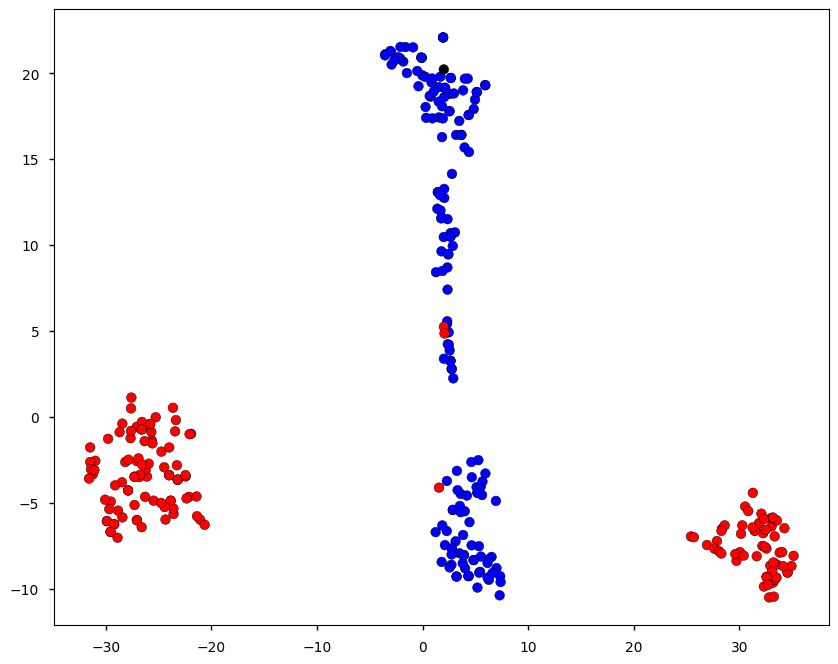

In [31]:
all_boxes_obs_test = np.concatenate([plot_layouts['traj_states'], obses])
all_boxes_actions_test = np.concatenate([plot_layouts['traj_actions'], actions])
all_boxes_nobs_test = np.concatenate([plot_layouts['traj_next_states'], next_obses])

dynamics_embedding_mean, std = iql_agent.network.select('dynamic_transformer')(all_boxes_obs_test, all_boxes_actions_test,
                                                                            all_boxes_nobs_test, train=False)

dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(std)
tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(tsne[:, 0], tsne[:, 1], 
            edgecolors='black',
            c=colors + ['black'] * obses.shape[0])

In [56]:
cur_layout = gc_whole_dataset.sample(256, layout_type=i, context_length=99)[1]

In [76]:
first_cond = cur_layout['traj_states'][jnp.unique(jnp.where(cur_layout['traj_states'][:, :, 0] == 3)[0])]
sec_cond = first_cond[jnp.unique(jnp.where(first_cond[:, :, 1] == 6)[0])]

In [117]:
first_layout_indxs = jnp.unique(jnp.where(plot_layouts['traj_states'][:, :, 0] == 3)[0])
first_layout_x = jax.tree_util.tree_map(lambda arr: arr[first_layout_indxs], plot_layouts)
first_layout_y = jnp.unique(jnp.where(first_layout_x['traj_states'][:, :, 1] == 6)[0])
first_layout_trajs = jax.tree_util.tree_map(lambda arr: arr[first_layout_y], first_layout_x)

In [121]:
second_layout_indxs = jnp.unique(jnp.where(jnp.any(plot_layouts['traj_states'][:, :, 0] == 3 and plot_layouts['traj_states'][:, :, 0] == 6))[0])
second_layout_x = jax.tree_util.tree_map(lambda arr: arr[second_layout_indxs], plot_layouts)
second_layout_y = jnp.unique(jnp.where(second_layout_x['traj_states'][:, :, 1] == 2)[0])
second_layout_trajs = jax.tree_util.tree_map(lambda arr: arr[second_layout_y], second_layout_x)

second_layout_indxs.shape

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [147]:
first_layout_indxs = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == 6.0), 1))[0]
first_layout_trajs = jax.tree_util.tree_map(lambda arr: arr[first_layout_indxs], plot_layouts)

sec_layout_indxs = jnp.where(jnp.any((plot_layouts['traj_states'][:, :, 0] == 3.0) & (plot_layouts['traj_states'][:, :, 1] == 2.0), 1))[0]
sec_layout_trajs = jax.tree_util.tree_map(lambda arr: arr[sec_layout_indxs], plot_layouts)